In [1]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection

import sys
sys.path.append("../../src")
import os
import numpy as np
import pickle
from example_thomas import simulate_thomas, get_thomas_data, generate_thomas_data
from example_lorenz import simulate_lorenz, get_lorenz_data, generate_lorenz_data

from autoencoder import full_network
from training import create_feed_dictionary
from sindy_utils import sindy_simulate

# compatibility issues
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#import tensorflow as tf


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


# Testing the simulate_thomas() function


We first plot the thomas' attractor and then the lorenz' one.

[ 1.29914689  2.43761544 -2.64021162]


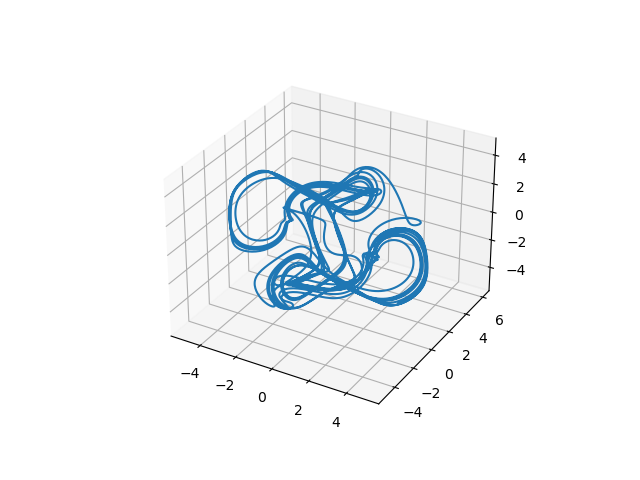

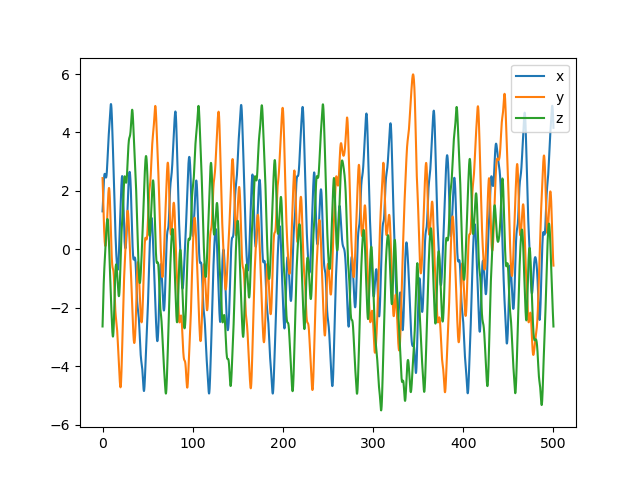

In [2]:
%matplotlib widget

t = np.linspace(0, 500, 5000)

x0 = np.random.uniform(-3, 3, size=(1, 3))[0]
print(x0)

sim_1 = simulate_thomas(x0, t, b = 0.1)

z, dz, ddz = sim_1


fig = plt.figure()
ax = plt.axes(projection='3d')


xdata = z[:,0]
ydata = z[:,1]
zdata = z[:,2]


ax.plot3D(xdata, ydata, zdata)
#fig.show()

fig2 = plt.figure()

plt.plot(t, xdata, label = "x")
plt.plot(t, ydata, label = "y")
plt.plot(t, zdata, label = "z")
plt.legend()
#fig2.show()
#


[ 1.06922321 -2.90850378  2.6856681 ]


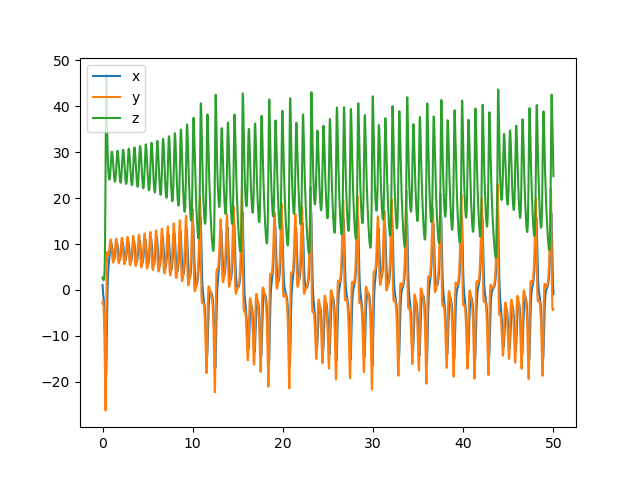

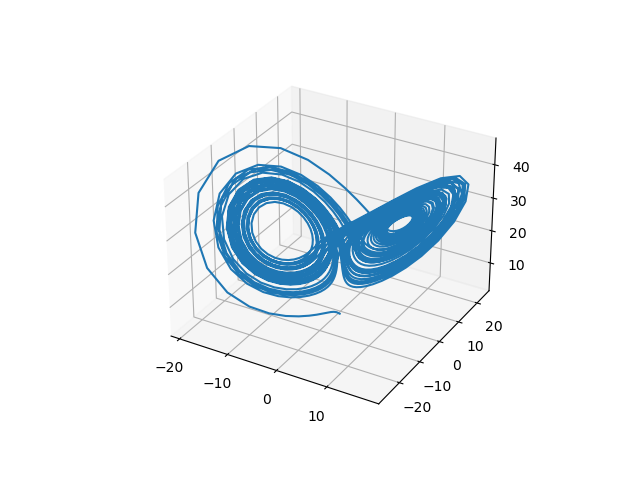

In [3]:
%matplotlib widget

t = np.linspace(0, 50, 2000)

x0 = np.random.uniform(-3, 3, size=(1, 3))[0]
print(x0)

sim_1 = simulate_lorenz(x0, t)

z, dz, ddz = sim_1


fig = plt.figure()
ax = plt.axes(projection='3d')


xdata = z[:,0]
ydata = z[:,1]
zdata = z[:,2]


ax.plot3D(xdata, ydata, zdata)
#fig.show()

fig2 = plt.figure()

plt.plot(t, xdata, label = "x")
plt.plot(t, ydata, label = "y")
plt.plot(t, zdata, label = "z")
plt.legend()
plt.show()
#fig2.show()
#


# Testing generate_thomas_data()

In [4]:
n_ics = 50
noise_strength=0

t = np.arange(0, 500, .2)
t = np.linspace(0, 500, 5000) # to be consistent with the previous test


n_steps = t.size
input_dim = 10

ic_means = np.array([0,0,25])
ic_widths = 2*np.array([36,48,41])

# training data
ics = ic_widths*(np.random.rand(n_ics, 3)-.5) + ic_means
data = generate_thomas_data(ics, t, input_dim, linear=True)


print(data['x'].shape)

(50, 5000, 10)


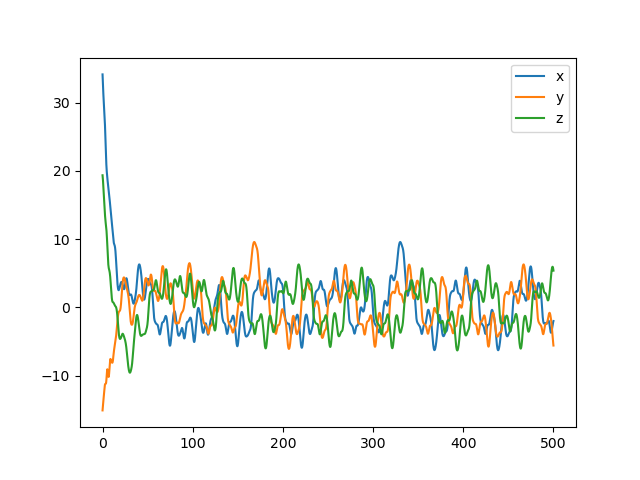

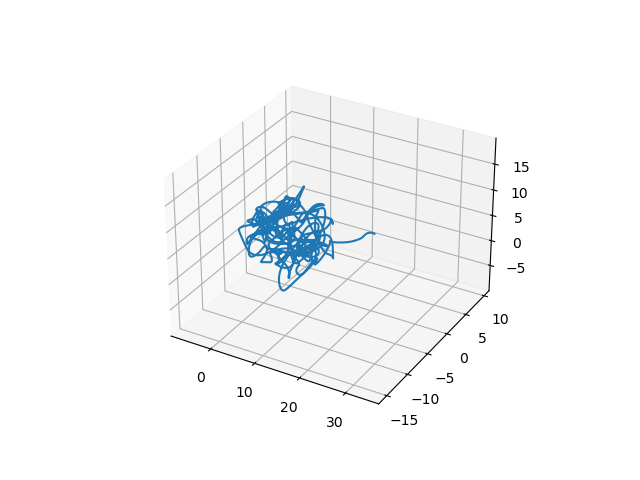

In [5]:
%matplotlib widget


# the second component is the time for sure

xdata = data['x'][1,:,1]
ydata = data['x'][2,:,1]
zdata = data['x'][3,:,1]



plt.plot(t, xdata , label = "x")
plt.plot(t, ydata , label = "y")
plt.plot(t, zdata , label = "z")

plt.legend()
#plt.show()

##### plot 3D


fig = plt.figure()
ax = plt.axes(projection='3d')





ax.plot3D(xdata, ydata, zdata)
#fig.show()


In [6]:
n_ics = 50
noise_strength=0

t = np.arange(0, 50, .02)
t = np.linspace(0, 50, 2000) # to be consistent with the previous test

n_steps = t.size
input_dim = 10

ic_means = np.array([0,0,25])
ic_widths = 2*np.array([36,48,41])

# training data
ics = ic_widths*(np.random.rand(n_ics, 3)-.5) + ic_means
data = generate_lorenz_data(ics, t, input_dim, linear=True)



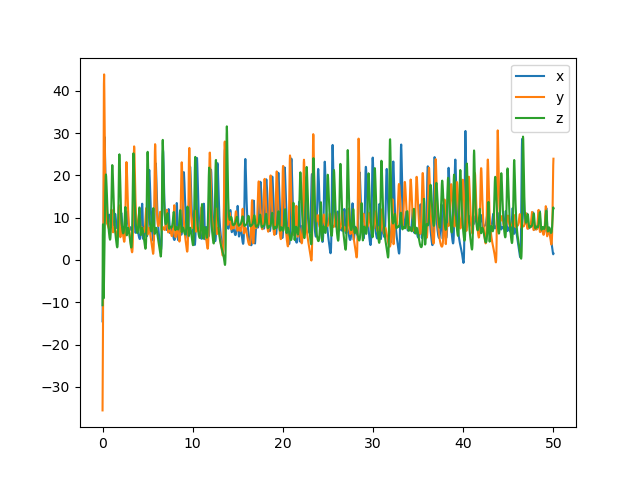

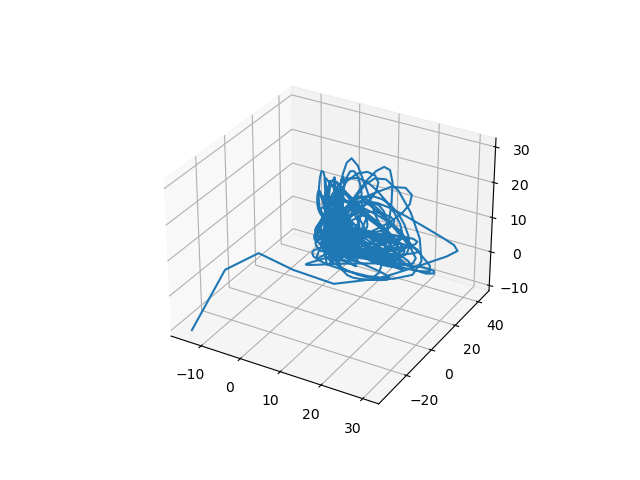

In [7]:
%matplotlib widget

# the second component is the time for sure

xdata = data['x'][1,:,1]
ydata = data['x'][2,:,1]
zdata = data['x'][3,:,1]



plt.plot(t, xdata , label = "x")
plt.plot(t, ydata , label = "y")
plt.plot(t, zdata , label = "z")

plt.legend()
plt.show()

##### plot 3D


fig = plt.figure()
ax = plt.axes(projection='3d')





ax.plot3D(xdata, ydata, zdata)
#fig.show()


# Test the trained model

In [6]:
data_path = os.getcwd() + '/'
save_name = 'model1'

#save_name = 'lorenz_2023_03_23_11_29_10_353401'  # 
#save_name = 'lorenz_2023_03_24_08_59_14_932988'  # 
save_name = 'lorenz_2023_03_24_12_06_01_972805'  # best one so far
#save_name = 'lorenz_2023_03_25_19_51_08_584998'  # 3rd poly order
#save_name = 'lorenz_2023_03_26_21_13_22_371388'  # 



params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

autoencoder_network = full_network(params)
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

## Single trajectory plots

In [7]:
t = np.arange(0,20,.01)
t = np.linspace(0, 500, 5000) # keeping it conscistent 


z0 = np.array([[-8,7,27]])

test_data = generate_thomas_data(z0, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40]))
test_data = generate_thomas_data(z0, t, params['input_dim'], linear=False) #test
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['z'] = test_data['z'].reshape((-1,params['latent_dim']))
test_data['dz'] = test_data['dz'].reshape((-1,params['latent_dim']))

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

INFO:tensorflow:Restoring parameters from /Users/aygalic/Library/CloudStorage/OneDrive-Personal/polimi/COURSES/S10/Computational Stats/SindyAutoencoders_v2/examples/thomas/lorenz_2023_03_24_12_06_01_972805


2023-03-27 00:16:59.672172: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-27 00:16:59.673257: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-27 00:16:59.696868: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-03-27 00:16:59.707946: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-27 00:16:59.713036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-27 00:16:59.780385: I tensorflow/core/grappler/optimizers/custom_graph

## Affine transformation of SINDy param

This part is not detailed in the original SINDy autoencoder paper but on the appendix 
https://www.pnas.org/doi/suppl/10.1073/pnas.1906995116/suppl_file/pnas.1906995116.sapp.pdf


One of the main thing to keep in mind being that you need a decent model where you can identify the params in order to manually provide a linear combinaison of those that could then be used in order to simulate the identified system.

In [9]:
import seaborn as sns

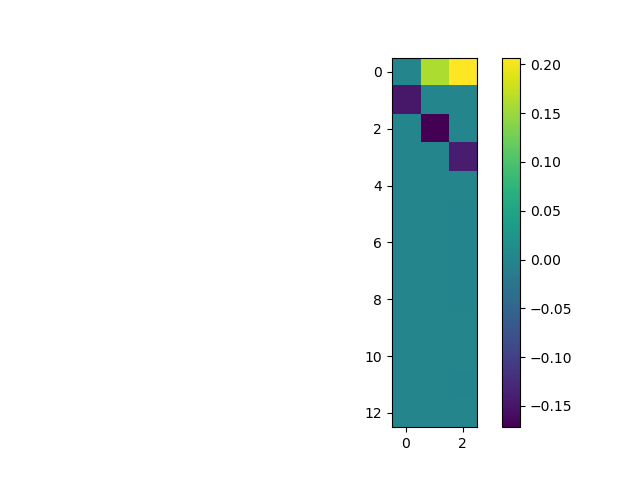

In [10]:
%matplotlib widget

coefs_ = test_set_results['sindy_coefficients']
coefs_

plt.imshow(coefs_)
plt.colorbar()

plt.show()


In [14]:
# This cell was used to linearly transform the discovered coeficcient into the system they wanted to discover

a1 = 1
a2 = test_data['sindy_coefficients'][2,0]/test_set_results['sindy_coefficients'][2,0]
a3 = np.sqrt(-test_set_results['sindy_coefficients'][5,2]/test_set_results['sindy_coefficients'][6,1]*a2**2)
b3 = -test_set_results['sindy_coefficients'][0,2]/test_set_results['sindy_coefficients'][3,2]

sindy_coefficients_transformed = np.zeros(test_set_results['sindy_coefficients'].shape)
sindy_coefficients_transformed[1,0] = test_set_results['sindy_coefficients'][1,0]
sindy_coefficients_transformed[2,0] = test_set_results['sindy_coefficients'][2,0]*a2/a1
sindy_coefficients_transformed[1,1] = test_set_results['sindy_coefficients'][6,1]*a1/a2*b3
sindy_coefficients_transformed[2,1] = test_set_results['sindy_coefficients'][2,1]
sindy_coefficients_transformed[6,1] = test_set_results['sindy_coefficients'][6,1]*a1*a3/a2
sindy_coefficients_transformed[3,2] = test_set_results['sindy_coefficients'][3,2]
sindy_coefficients_transformed[5,2] = test_set_results['sindy_coefficients'][5,2]*a1*a2/a3

z0_transformed = np.array([test_set_results['z'][0,0]/a1,
                           test_set_results['z'][0,1]/a2,
                           (test_set_results['z'][0,2] - b3)/a3])

/var/folders/xr/0fvz4r2s4wx1hx13jlhxj2z00000gn/T/ipykernel_11552/957513862.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  sindy_coefficients_transformed[1,1] = test_set_results['sindy_coefficients'][6,1]*a1/a2*b3
/var/folders/xr/0fvz4r2s4wx1hx13jlhxj2z00000gn/T/ipykernel_11552/957513862.py:11: RuntimeWarning: invalid value encountered in double_scalars
  sindy_coefficients_transformed[6,1] = test_set_results['sindy_coefficients'][6,1]*a1*a3/a2
/var/folders/xr/0fvz4r2s4wx1hx13jlhxj2z00000gn/T/ipykernel_11552/957513862.py:13: RuntimeWarning: invalid value encountered in double_scalars
  sindy_coefficients_transformed[5,2] = test_set_results['sindy_coefficients'][5,2]*a1*a2/a3
/var/folders/xr/0fvz4r2s4wx1hx13jlhxj2z00000gn/T/ipykernel_11552/957513862.py:16: RuntimeWarning: divide by zero encountered in float_scalars
  test_set_results['z'][0,1]/a2,
/var/folders/xr/0fvz4r2s4wx1hx13jlhxj2z00000gn/T/ipykernel_11552/957513862.py:17: RuntimeWarning: divide by zero encount

In [15]:
a1 = 1
sa3 = np.sqrt(-test_set_results['sindy_coefficients'][5,2]/test_set_results['sindy_coefficients'][6,1]*a2**2)
b3 = -test_set_results['sindy_coefficients'][0,2]/test_set_results['sindy_coefficients'][3,2]

sindy_coefficients_transformed = np.zeros(test_set_results['sindy_coefficients'].shape)
sindy_coefficients_transformed[1,0] = test_set_results['sindy_coefficients'][1,0]
sindy_coefficients_transformed[2,0] = test_set_results['sindy_coefficients'][2,0]*a2/a1
sindy_coefficients_transformed[1,1] = test_set_results['sindy_coefficients'][6,1]*a1/a2*b3
sindy_coefficients_transformed[2,1] = test_set_results['sindy_coefficients'][2,1]
sindy_coefficients_transformed[6,1] = test_set_results['sindy_coefficients'][6,1]*a1*a3/a2
sindy_coefficients_transformed[3,2] = test_set_results['sindy_coefficients'][3,2]
sindy_coefficients_transformed[5,2] = test_set_results['sindy_coefficients'][5,2]*a1*a2/a3

z0_transformed = np.array([test_set_results['z'][0,0]/a1,
                           test_set_results['z'][0,1]/a2,
                           (test_set_results['z'][0,2] - b3)/a3])

/var/folders/xr/0fvz4r2s4wx1hx13jlhxj2z00000gn/T/ipykernel_11552/206949834.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  sindy_coefficients_transformed[1,1] = test_set_results['sindy_coefficients'][6,1]*a1/a2*b3
/var/folders/xr/0fvz4r2s4wx1hx13jlhxj2z00000gn/T/ipykernel_11552/206949834.py:10: RuntimeWarning: invalid value encountered in double_scalars
  sindy_coefficients_transformed[6,1] = test_set_results['sindy_coefficients'][6,1]*a1*a3/a2
/var/folders/xr/0fvz4r2s4wx1hx13jlhxj2z00000gn/T/ipykernel_11552/206949834.py:12: RuntimeWarning: invalid value encountered in double_scalars
  sindy_coefficients_transformed[5,2] = test_set_results['sindy_coefficients'][5,2]*a1*a2/a3
/var/folders/xr/0fvz4r2s4wx1hx13jlhxj2z00000gn/T/ipykernel_11552/206949834.py:15: RuntimeWarning: divide by zero encountered in float_scalars
  test_set_results['z'][0,1]/a2,
/var/folders/xr/0fvz4r2s4wx1hx13jlhxj2z00000gn/T/ipykernel_11552/206949834.py:16: RuntimeWarning: divide by zero encount

In [19]:
#def sindy_simulate(x0, t, Xi, poly_order, include_sine):
#    m = t.size
#    n = x0.size
#    f = lambda x,t : np.dot(sindy_library(np.array(x).reshape((1,n)), poly_order, include_sine), Xi).reshape((n,))
#
#    x = odeint(f, x0, t)
#    return x
    

In [9]:
from sindy_utils import sindy_library

In [34]:
print(np.array(((1,2),(3,4))))
print(np.array(((1,2),(3,4)))[0,1])






[[1 2]
 [3 4]]
2


In [36]:
from scipy.special import binom
from scipy.integrate import odeint

def library_size(n, poly_order, use_sine=False, include_constant=True):
    l = 0
    for k in range(poly_order+1):
        l += int(binom(n+k-1,k))
    if use_sine:
        l += n
    if not include_constant:
        l -= 1
    return l


def sindy_library(X, poly_order, include_sine=False):
    # modified version with sin coming earlier in the coefs
    
    m,n = X.shape
    l = library_size(n, poly_order, include_sine, True)
    library = np.ones((m,l))
    index = 1

    for i in range(n):
        library[:,index] = X[:,i]
        index += 1
    
    if include_sine:
        for i in range(n):
            library[:,index] = np.sin(X[:,i])
            index += 1

    if poly_order > 1:
        for i in range(n):
            for j in range(i,n):
                library[:,index] = X[:,i]*X[:,j]
                index += 1

    if poly_order > 2:
        for i in range(n):
            for j in range(i,n):
                for k in range(j,n):
                    library[:,index] = X[:,i]*X[:,j]*X[:,k]
                    index += 1

    if poly_order > 3:
        for i in range(n):
            for j in range(i,n):
                for k in range(j,n):
                    for q in range(k,n):
                        library[:,index] = X[:,i]*X[:,j]*X[:,k]*X[:,q]
                        index += 1
                    
    if poly_order > 4:
        for i in range(n):
            for j in range(i,n):
                for k in range(j,n):
                    for q in range(k,n):
                        for r in range(q,n):
                            library[:,index] = X[:,i]*X[:,j]*X[:,k]*X[:,q]*X[:,r]
                            index += 1



    return library


In [11]:
test_data['sindy_coefficients']


array([[ 0. ,  0. ,  0. ],
       [-0.1,  0. ,  0. ],
       [ 0. , -0.1,  0. ],
       [ 0. ,  0. , -0.1],
       [ 0. ,  0. ,  1. ],
       [ 1. ,  0. ,  0. ],
       [ 0. ,  1. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ]], dtype=float32)

In [12]:
params['coefficient_mask']*test_set_results['sindy_coefficients']


array([[-0.        ,  0.16023819,  0.20698501],
       [-0.14679591, -0.        ,  0.        ],
       [-0.        , -0.17182346,  0.        ],
       [-0.        , -0.        , -0.14159384],
       [ 0.        , -0.        ,  0.        ],
       [-0.        , -0.        , -0.        ],
       [ 0.        ,  0.        , -0.        ],
       [ 0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        , -0.        , -0.        ],
       [ 0.        , -0.        , -0.        ]], dtype=float32)

In [37]:
x0 = test_data['z'][0]
n = x0.size
Xi = test_data['sindy_coefficients']
poly_order = params['poly_order']
include_sine = params['include_sine']

x = x0
print(sindy_library(np.array(x).reshape((1,n)), poly_order, include_sine))

f = lambda x,t : np.dot(sindy_library(np.array(x).reshape((1,n)), poly_order, include_sine), Xi).reshape((n,))



f(x0, t)


[[ 1.00000000e+00 -8.00000000e+00  7.00000000e+00  2.70000000e+01
  -9.89358247e-01  6.56986599e-01  9.56375928e-01  6.40000000e+01
  -5.60000000e+01 -2.16000000e+02  4.90000000e+01  1.89000000e+02
   7.29000000e+02]]


ValueError: shapes (1,13) and (20,3) not aligned: 13 (dim 1) != 20 (dim 0)

ValueError: cannot reshape array of size 3 into shape (3,3)

In [37]:
print(test_data['z'][0].shape)
print(test_data['sindy_coefficients'].shape)
print(params['poly_order'])
print(params['include_sine'])

(3,)
(20, 3)
2
True


In [25]:





thomas_sim = sindy_simulate(test_data['z'][0], t, test_data['sindy_coefficients'],
                            params['poly_order'], params['include_sine'])
#z_sim = sindy_simulate(test_set_results['z'][0], t, params['coefficient_mask']*test_set_results['sindy_coefficients'],
#                            params['poly_order'], params['include_sine'])

#z_sim_transformed = sindy_simulate(z0_transformed, t, sindy_coefficients_transformed,
#                                   params['poly_order'], params['include_sine'])

ValueError: shapes (1,13) and (20,3) not aligned: 13 (dim 1) != 20 (dim 0)

NameError: name 'z_sim' is not defined

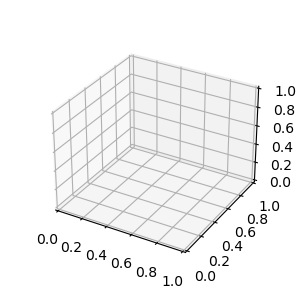

In [14]:
fig1 = plt.figure(figsize=(3,3))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(z_sim[:,0], z_sim[:,1], z_sim[:,2], linewidth=2)
plt.axis('off')
ax1.view_init(azim=120)

fig2 = plt.figure(figsize=(3,3))
ax2 = fig2.add_subplot(111, projection='3d')
#ax2.plot(z_sim_transformed[:,0], z_sim_transformed[:,1], z_sim_transformed[:,2], linewidth=2)
plt.axis('off')
ax2.view_init(azim=120)

fig3 = plt.figure(figsize=(3,3))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot(thomas_sim[:,0], thomas_sim[:,1], thomas_sim[:,2], linewidth=2)
plt.xticks([])
plt.axis('off')
ax3.view_init(azim=120)

NameError: name 'z_sim' is not defined

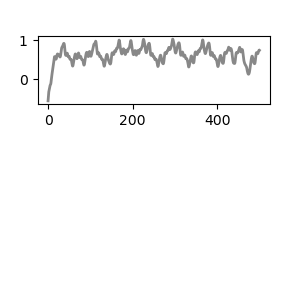

In [15]:
plt.figure(figsize=(3,3))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(t, test_set_results['z'][:,i], color='#888888', linewidth=2)
    plt.plot(t, z_sim[:,i], '--', linewidth=2)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

NameError: name 'sindy_coefficients_transformed' is not defined

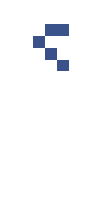

In [16]:
Xi_plot = (params['coefficient_mask']*test_set_results['sindy_coefficients'])
Xi_plot[Xi_plot==0] = np.inf
plt.figure(figsize=(1,2))
plt.imshow(Xi_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

Xi_transformed_plot = np.copy(sindy_coefficients_transformed)
Xi_transformed_plot[Xi_transformed_plot==0] = np.inf
plt.figure(figsize=(1,2))
plt.imshow(Xi_transformed_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

Xi_true_plot = np.copy(test_data['sindy_coefficients'])
Xi_true_plot[Xi_true_plot==0] = np.inf
Xi_true_plot[6,1] = -1.
Xi_true_plot[5,2] = 1.
plt.figure(figsize=(1,2))
plt.imshow(Xi_true_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

## Test set analysis - in distribution

In [ ]:
test_data = get_lorenz_data(100, noise_strength=1e-6)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /Users/aygalic/OneDrive/polimi/COURSES/S10/Computational Stats/SindyAutoencoders_v2/examples/lorenz/model1


2022-12-28 11:47:04.406091: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-28 11:47:04.406158: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-28 11:47:04.416270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-28 11:47:04.441773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-28 11:47:04.467604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.000028
Decoder relative SINDy error: 0.000219
SINDy reltive error, z: 0.000865


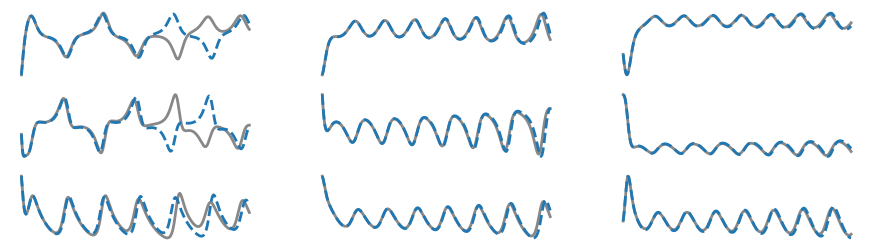

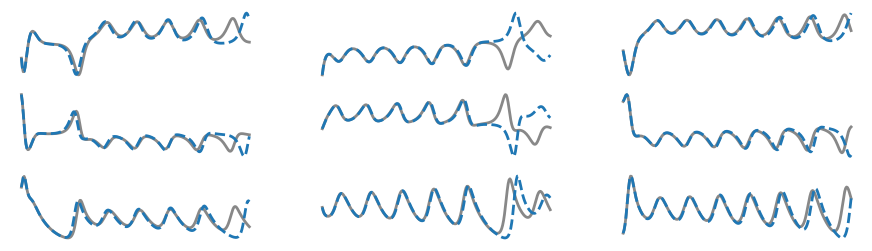

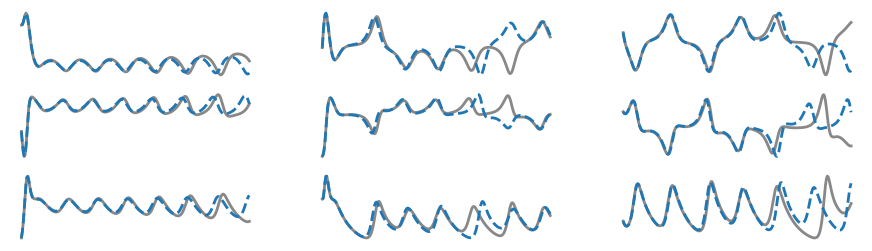

In [ ]:
for ic in range(9):
    idxs = np.arange(ic*250,(ic+1)*250)
    
    z_sim = sindy_simulate(test_set_results['z'][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results['sindy_coefficients'],
                           params['poly_order'], params['include_sine'])
    
    col_idx = ic % 3
    
    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        plt.plot(test_data['t'], test_set_results['z'][idxs,i], color='#888888', linewidth=2)
        plt.plot(test_data['t'], z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
#         plt.ylim(ylims[i])
        plt.axis('off')

## Test set analysis - out of distribution

In [ ]:
inDist_ic_widths = np.array([36,48,41])
outDist_extra_width = np.array([18,24,20])
full_width = inDist_ic_widths + outDist_extra_width

t = np.arange(0, 5, .02)
n_ics = 100

i = 0
ics = np.zeros((n_ics,3))
while i < n_ics:
    
    ic = np.array([np.random.uniform(-full_width[0],full_width[0]),
                   np.random.uniform(-full_width[1],full_width[1]),
                   np.random.uniform(-full_width[2],full_width[2]) + 25])
    if ((ic[0] > -inDist_ic_widths[0]) and (ic[0] < inDist_ic_widths[0])) \
        and ((ic[1] > -inDist_ic_widths[1]) and (ic[1] < inDist_ic_widths[1])) \
        and ((ic[2] > 25-inDist_ic_widths[2]) and (ic[2] < 25+inDist_ic_widths[2])):
        continue
    else:
        ics[i] = ic
        i += 1
        
noise_strength = 1e-6

# training test_data
test_data = generate_lorenz_data(ics, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40]))
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['x'] += noise_strength*np.random.normal(size=test_data['x'].shape)
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['dx'] += noise_strength*np.random.normal(size=test_data['dx'].shape)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /Users/aygalic/OneDrive/polimi/COURSES/S10/Computational Stats/SindyAutoencoders_v2/examples/lorenz/model1


2022-12-28 11:47:29.141702: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-28 11:47:29.141774: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-28 11:47:29.149493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-28 11:47:29.175911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-28 11:47:29.216440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.013248
Decoder relative SINDy error: 0.117635
SINDy reltive error, z: 0.095102


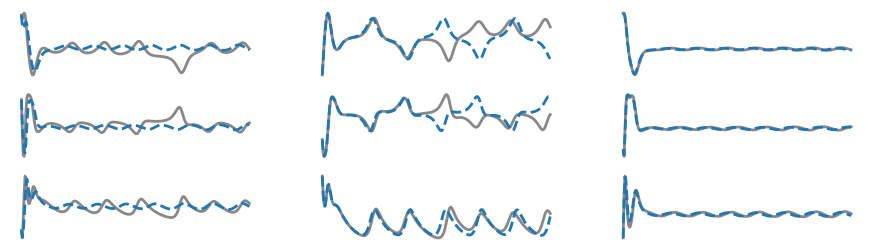

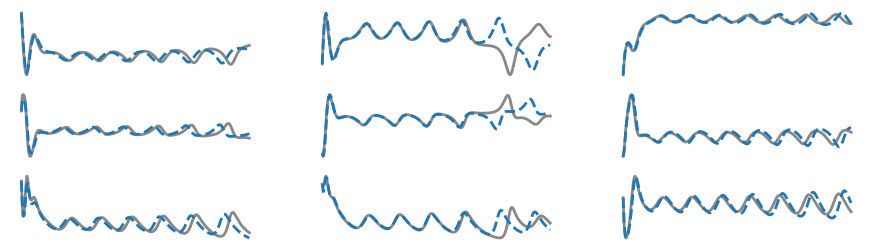

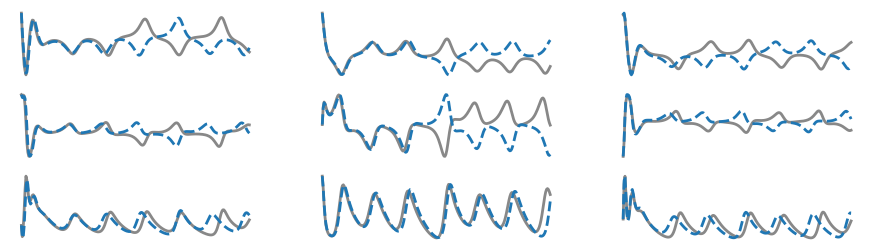

In [ ]:
for ic in range(9):
    idxs = np.arange(ic*250,(ic+1)*250)
    
    z_sim = sindy_simulate(test_set_results['z'][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results['sindy_coefficients'],
                           params['poly_order'], params['include_sine'])
    
    col_idx = ic % 3
    
    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        plt.plot(test_data['t'], test_set_results['z'][idxs,i], color='#888888', linewidth=2)
        plt.plot(test_data['t'], z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
#         plt.ylim(ylims[i])
        plt.axis('off')